# Stations network (summer 2018, weekend)


In [1]:
%matplotlib inline 
#%matplotlib inline notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplleaflet
import pandas as pd
import numpy as np
import json
import math
from matplotlib import cm

import networkx as nx
import matplotlib.pyplot as plt

#import os

#os.environ['PROJ_LIB'] = r'C:\Users\pgsze\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'

from mpl_toolkits.basemap import Basemap

# Import, and set to log to the console.  (See the console which is running
# Jupyter notebook for logging about HTTP requests.)
#import tilemapbase
#tilemapbase.start_logging()

In [2]:
###
subs_df = pd.read_pickle('../data/pickledDFs/subs_df-NYC_Summer_2018.pkl')
stations_info_df = pd.read_pickle('../data/pickledDFs/stations_info_df-NYC_Summer_2018.pkl')
subs_trips_df = pd.read_pickle('../data/pickledDFs/subs_trips_df-NYC_Summer_2018.pkl')
###

In [3]:
subs_df[subs_df['start station latitude']>41]

Empty DataFrame
Columns: [tripduration, starttime, stoptime, start station id, start station name, start station latitude, start station longitude, end station id, end station name, end station latitude, end station longitude, bikeid, usertype, birth year, gender]
Index: []

In [4]:
#Number of weekend days and weekday days for Jan - March 2018
#num_WE = 25
#num_WD = 31+28+31-num_WE #Note I'm not subtracting holidays here, maybe later...

In [5]:
weekday_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] != 'Weekend'].copy()
weekend_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] == 'Weekend'].copy()

In [6]:
#Need to filter out stations in stations_info_df that do not appear in weekday_subs_trips
station_drops = []
WE_unique = np.unique(np.concatenate((weekend_subs_trips_df['start station id'].unique(),weekend_subs_trips_df['end station id'].unique())))

for ind in stations_info_df.index:
    if not (ind in WE_unique):
        station_drops.append(ind)
        
print(station_drops)

stations_info_df.drop(station_drops,inplace=True)
len(stations_info_df) == len(WE_unique)

[3036, 3240, 3485, 3683, 3704, 493, 3040, 3267, 3275, 3214, 3199, 3270, 3183, 3103, 3487, 3198, 3213, 3203, 3192, 3268]


True

In [8]:
weekend_subs_trips_df.head()

tripduration               starttime                stoptime  \
155           449 2018-06-02 00:38:55.625 2018-06-02 00:46:25.314   
158           743 2018-06-02 02:00:16.492 2018-06-02 02:12:39.978   
159           357 2018-06-02 07:10:46.644 2018-06-02 07:16:44.311   
160           521 2018-06-02 07:32:45.649 2018-06-02 07:41:27.025   
161           382 2018-06-02 07:39:52.955 2018-06-02 07:46:15.558   

     start station id  end station id  bikeid    usertype  birth year  gender  \
155                72             529   32944  Subscriber        1988       1   
158                72             500   14980  Subscriber        1999       1   
159                72             457   18840  Subscriber        1981       1   
160                72             533   31040  Subscriber        1981       1   
161                72            3173   19164  Subscriber        1987       1   

     start_day  stop_day  pickup_hour  dropoff_hour  age Trip_Type  \
155          5         5            0             0   30   Weekend   
158          5         5            2             2   19   Weekend   
159          5         5            7             7   37   Weekend   
160          5         5            7             7   37   Weekend   
161          5         5            7             7   31   Weekend   

    start_end_station  
155         (72, 529)  
158         (72, 500)  
159         (72, 457)  
160         (72, 533)  
161        (72, 3173)

In [9]:
edge_list_ser = weekend_subs_trips_df.groupby('start_end_station').count()['bikeid']
edge_list_ser = edge_list_ser[edge_list_ser > 10]
len(edge_list_ser)

24780

In [10]:
G = nx.Graph()

In [11]:
w_edge_list = [(i[0],i[1],edge_list_ser[i]) for i in edge_list_ser.index]

In [12]:
G.add_weighted_edges_from(w_edge_list,weight='num_trips')

In [13]:
num_out_df = weekend_subs_trips_df.groupby('start station id').count()['bikeid']
num_in_df = weekend_subs_trips_df.groupby('end station id').count()['bikeid']

tot_df = num_in_df+num_out_df

tot_df.head()

72     4565.0
79     2762.0
82     1352.0
83     2480.0
119     360.0
Name: bikeid, dtype: float64

In [14]:
btwn_centrality_ser = pd.Series(nx.betweenness_centrality(G,normalized=True, endpoints=False))
close_centrality_ser = pd.Series(nx.closeness_centrality(G,wf_improved=True))

In [15]:
import tilemapbase
tilemapbase.start_logging()

In [16]:
NYC_center = (-74.006,40.713)
NYC_center_moves = []

for num in range(5):
    NYC_center_moves.append(tuple([NYC_center[0]+num*.001,NYC_center[1]+num*.001]))

extent = tilemapbase.Extent.from_lonlat(-74.03,-73.91, 40.65, 40.81)

#extent = extent.to_aspect(1)
extent

Extent((0.29436111111111113,0.3756243319633231)->(0.2946944444444445,0.37621083107798253) projected as normal)

In [17]:
t = tilemapbase.tiles.Carto_Light

In [18]:
for node in G.nodes():
    G.nodes[node]['Location']= (stations_info_df.loc[node]['lon'],stations_info_df.loc[node]['lat'])
    G.nodes[node]['TMB_loc']= tilemapbase.project(nx.get_node_attributes(G,'Location')[node][0],nx.get_node_attributes(G,'Location')[node][1])
    G.nodes[node]['usage']= tot_df.loc[node]

## Degree as node color

the degree node v is the number of edges connected to it

C:\Users\pgsze\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


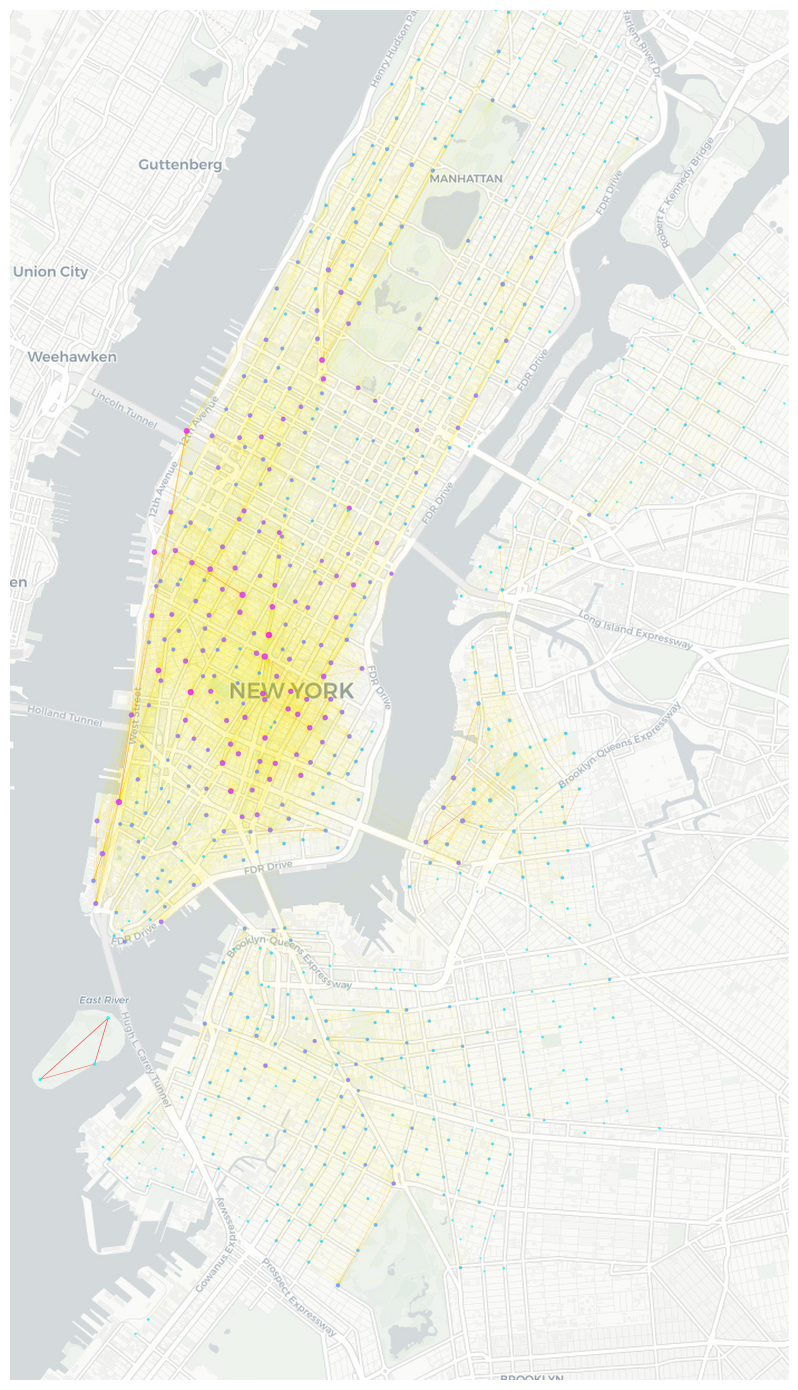

In [19]:
#node color = degree
fig, ax = plt.subplots(figsize=(14,14), dpi=100)
    
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)


node_color = [G.degree(v) for v in G]
#node_color = [btwn_centrality_ser.loc[node]/btwn_centrality_ser.max() for node in G.nodes()]
#node_color = [close_centrality_ser.loc[node]/close_centrality_ser.max() for node in G.nodes()]
node_size = [0.001*nx.get_node_attributes(G, 'usage')[v] for v in G]
#pos = nx.get_node_attributes(G,'Location')
pos=nx.get_node_attributes(G,'TMB_loc')
edge_width = [0.0005*G[u][v]['num_trips'] for u,v in G.edges()]

nx.draw_networkx(G, pos, node_size=node_size, 
                 node_color=node_color, alpha=.7, with_labels=False, 
                 width=edge_width, #edge_color='.4', 
                 cmap=plt.cm.cool,
                 vmin=sorted(node_color)[0],vmax = sorted(node_color)[-1],
                 edge_color = list(nx.get_edge_attributes(G,'num_trips').values()),
                 edge_cmap = plt.cm.autumn_r,
                 edge_vmin = sorted(nx.get_edge_attributes(G,'num_trips').values())[0], edge_vmax = sorted(nx.get_edge_attributes(G,'num_trips').values())[-1])

plt.axis('off')
plt.tight_layout();

## Betweenness centrality as node color 
betweenness centrality of node v is the sum over all pairs of nodes s, t in the graph of the percentage of shortest paths between s, t that contain node v

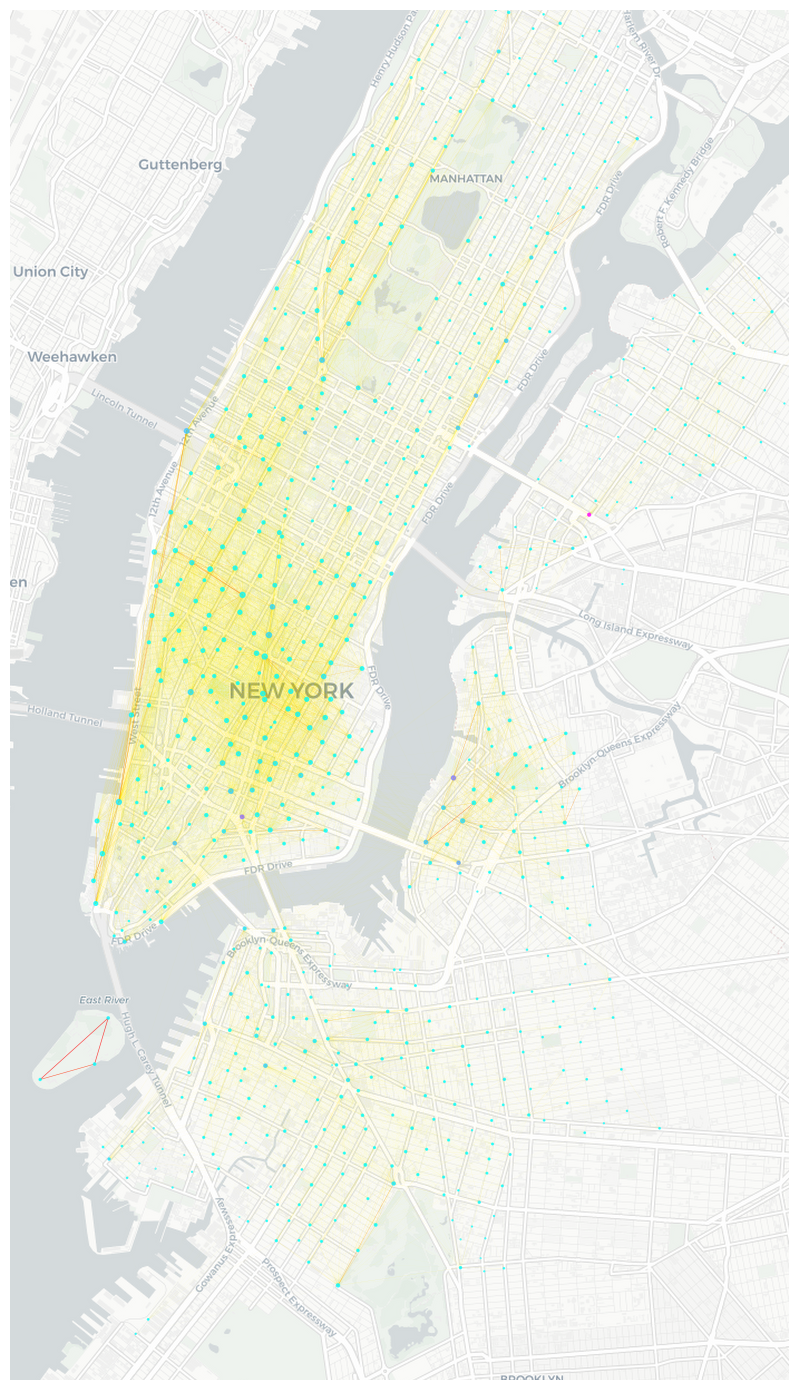

In [20]:
#node color = degree
fig, ax = plt.subplots(figsize=(14,14), dpi=100)
    
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)


#node_color = [G.degree(v) for v in G]
btwn_max = btwn_centrality_ser.max()
node_color = [btwn_centrality_ser.loc[node]/btwn_max for node in G.nodes()]
#node_color = [close_centrality_ser.loc[node]/close_centrality_ser.max() for node in G.nodes()]
node_size = [0.001*nx.get_node_attributes(G, 'usage')[v] for v in G]
#pos = nx.get_node_attributes(G,'Location')
pos=nx.get_node_attributes(G,'TMB_loc')
edge_width = [0.0005*G[u][v]['num_trips'] for u,v in G.edges()]

nx.draw_networkx(G, pos, node_size=node_size, 
                 node_color=node_color, alpha=.7, with_labels=False, 
                 width=edge_width, #edge_color='.4', 
                 cmap=plt.cm.cool,
                 vmin=sorted(node_color)[0],vmax = sorted(node_color)[-1],
                 edge_color = list(nx.get_edge_attributes(G,'num_trips').values()),
                 edge_cmap = plt.cm.autumn_r,
                 edge_vmin = sorted(nx.get_edge_attributes(G,'num_trips').values())[0], edge_vmax = sorted(nx.get_edge_attributes(G,'num_trips').values())[-1])

plt.axis('off')
plt.tight_layout();

## Closeness centrality as node color

closeness centrality of a node v is defined as the inverse of the sum of the shorest path distances between node v and every other connected node in the graph

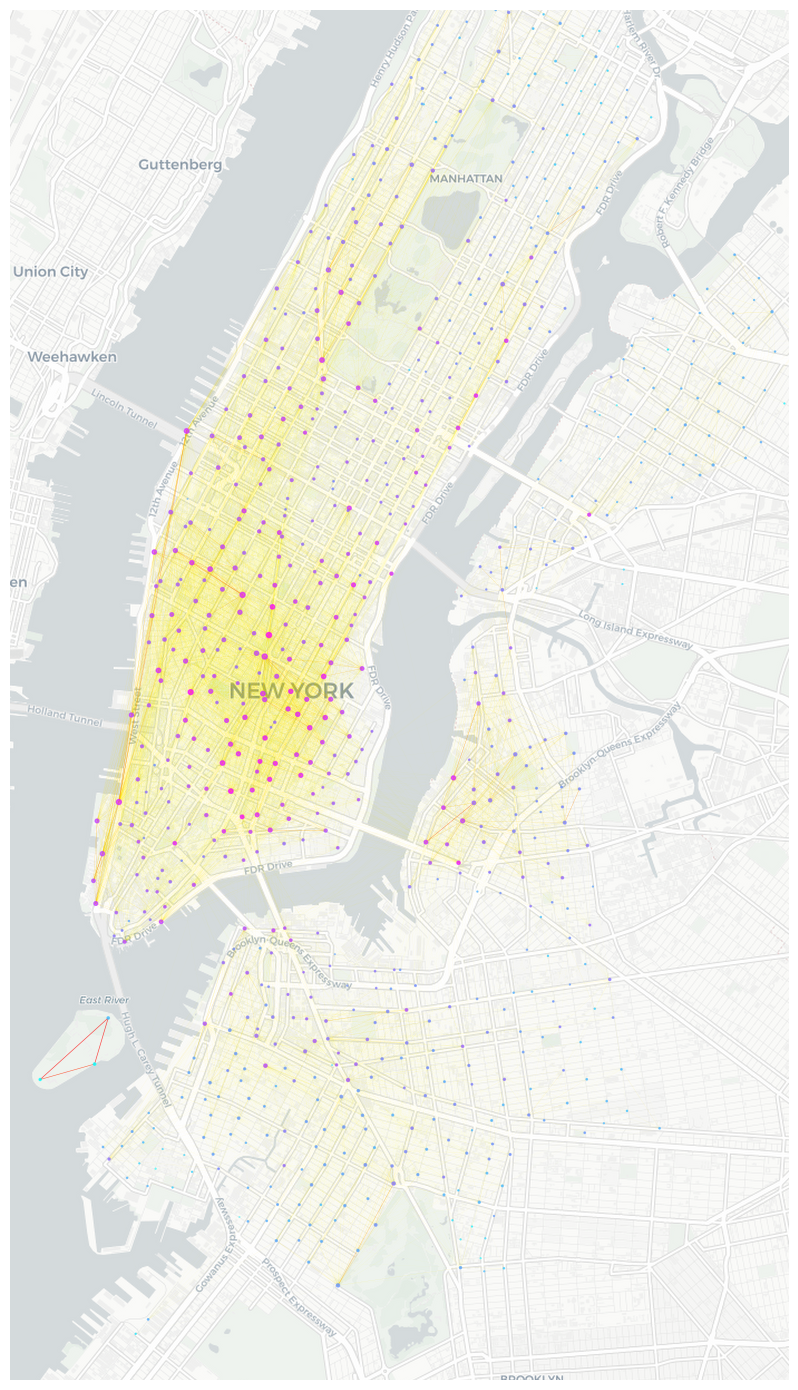

In [21]:
#node color = degree
fig, ax = plt.subplots(figsize=(14,14), dpi=100)
    
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)


#node_color = [G.degree(v) for v in G]
#node_color = [btwn_centrality_ser.loc[node]/btwn_centrality_ser.max() for node in G.nodes()]
close_max=close_centrality_ser.max()
node_color = [close_centrality_ser.loc[node]/close_max for node in G.nodes()]
node_size = [0.001*nx.get_node_attributes(G, 'usage')[v] for v in G]
#pos = nx.get_node_attributes(G,'Location')
pos=nx.get_node_attributes(G,'TMB_loc')
edge_width = [0.0005*G[u][v]['num_trips'] for u,v in G.edges()]

nx.draw_networkx(G, pos, node_size=node_size, 
                 node_color=node_color, alpha=.7, with_labels=False, 
                 width=edge_width, #edge_color='.4', 
                 cmap=plt.cm.cool,
                 #there is one node with CC=zero, which I am dropping in v_range
                 vmin=sorted(node_color)[1],vmax = sorted(node_color)[-1],
                 edge_color = list(nx.get_edge_attributes(G,'num_trips').values()),
                 edge_cmap = plt.cm.autumn_r,
                 edge_vmin = sorted(nx.get_edge_attributes(G,'num_trips').values())[0], edge_vmax = sorted(nx.get_edge_attributes(G,'num_trips').values())[-1])

plt.axis('off')
plt.tight_layout();